In [14]:
import pickle as pkl
import pandas as pd
import lightgbm as lgb
from scipy import stats
from scipy.stats import ttest_ind
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
sys.path.append("msc_thesis/hbac scripts")
import hbac_kmeans
from sklearn import metrics
import shap
from statistics import mean

# Effect of amount of features

In [18]:
# Get completed dataset with all features, no missing values
df = pd.read_pickle('completed_dataset.pkl')

## Get list of most important features according to SHAP on ERV model
sorted_features = pkl.load(open('sorted_features.pkl', 'rb'))

In [20]:
### Add 1 features to HBAC analysis, untill 40 features. Calculate Silhouette score and max negative bias found. 
biases = []
bias_std = []
sillh_list = []
std_sillh = []
number_of_clusters = []
std_number_of_clusters = []
# DB_list = []
# CH_list = []
FEATURE_AMOUNT = 40

for number_of_features in range(1,FEATURE_AMOUNT):
    
    feature_set = sorted_features[:number_of_features]
    feature_set.extend(['predicted_value','true_value', 'errors'])

    avg_bias = []
    avg_sillh = []
    avg_number_of_clusters = []
    
    # Run experiment 5 times with this feature set
    for i in range(5):
        results = hbac_kmeans.hbac_kmeans(df[feature_set], 0.8, show_plot=False)
        c, max_neg_bias = hbac_kmeans.get_max_bias_cluster(results)
        avg_bias.append(max_neg_bias)
        avg_sillh.append(metrics.silhouette_score( results.drop(['clusters', 'new_clusters', 'predicted_value', 'true_value', 'errors'], axis=1),
                                              results['clusters']))
        avg_number_of_clusters.append(len(results['clusters'].unique()) )
#         DB_score = metrics.davies_bouldin_score(results.drop(['clusters', 'new_clusters', 'predicted_value', 'true_value', 'errors'], axis=1),
#                                         results['clusters'])
#         CH_index = metrics.calinski_harabasz_score(results.drop(['clusters', 'new_clusters', 'predicted_value', 'true_value', 'errors'], axis=1),
#                                         results['clusters'])

    biases.append(mean(avg_bias))
    bias_std.append(np.std(avg_bias))
    sillh_list.append(mean(avg_sillh))
    std_sillh.append(np.std(avg_sillh))
    number_of_clusters.append(mean(avg_number_of_clusters))
    std_number_of_clusters.append(np.std(avg_number_of_clusters))
    

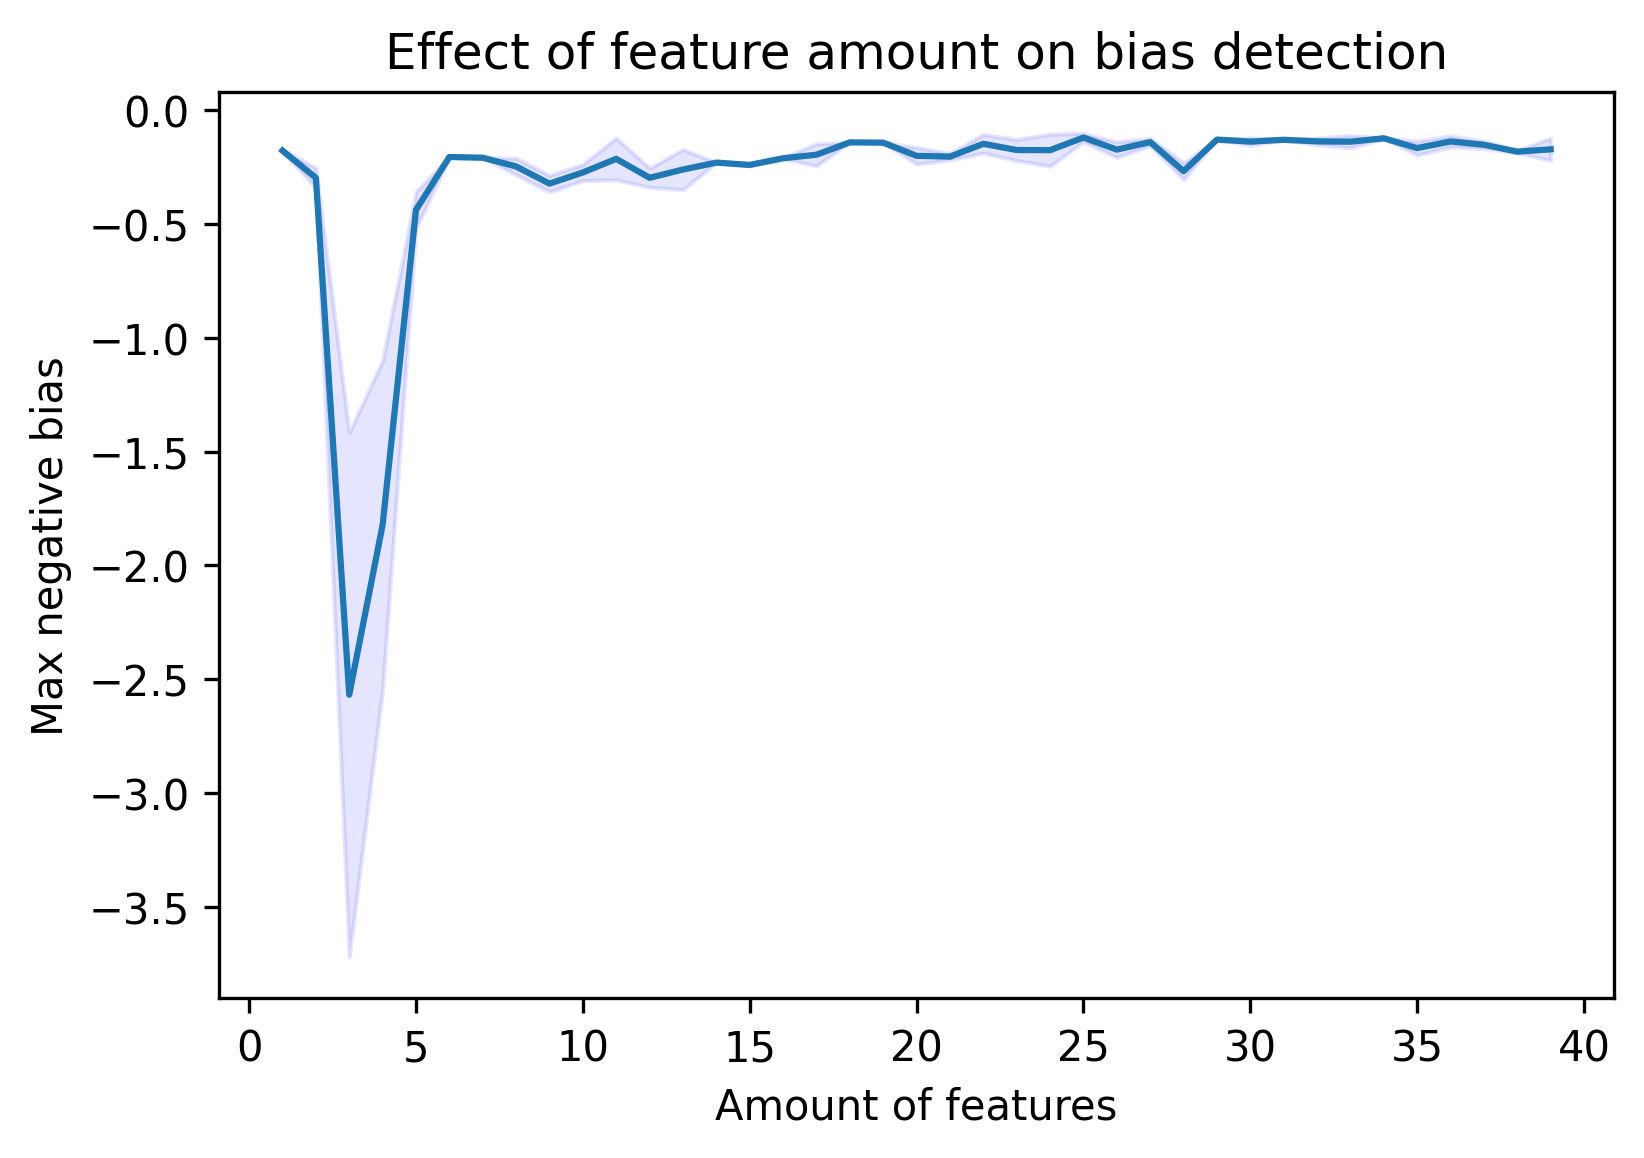

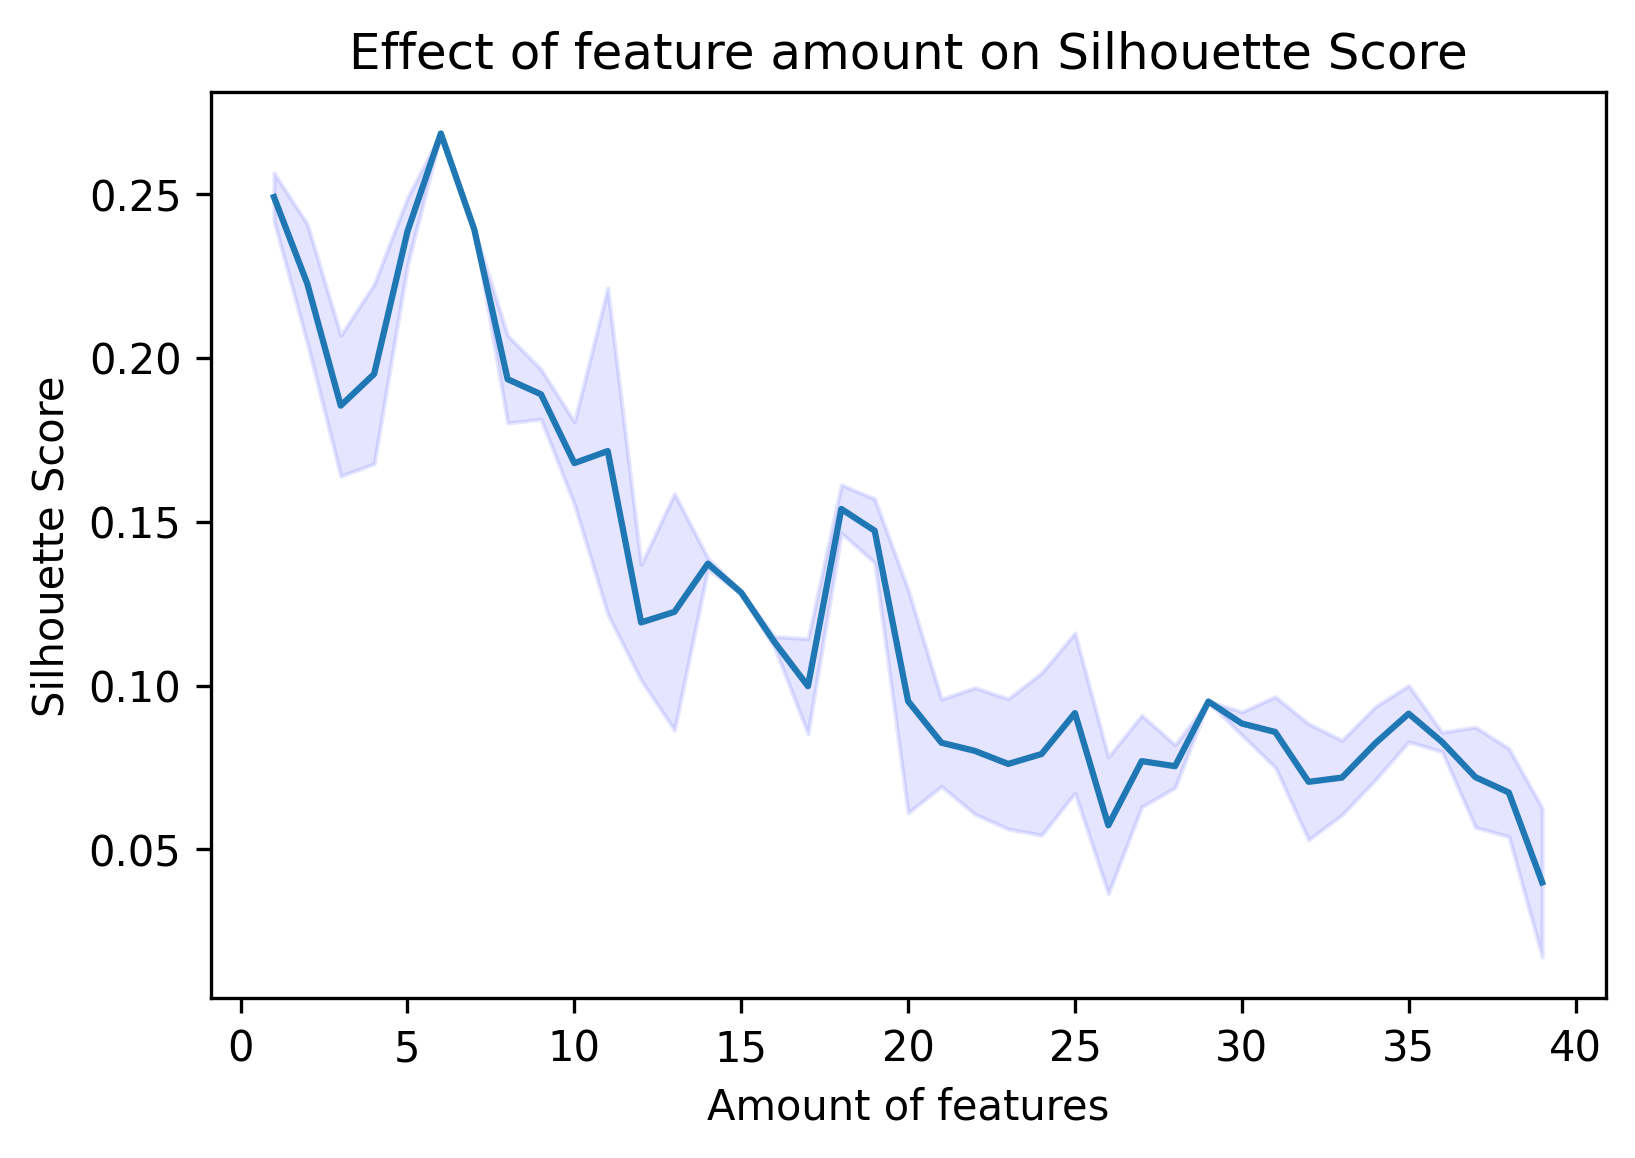

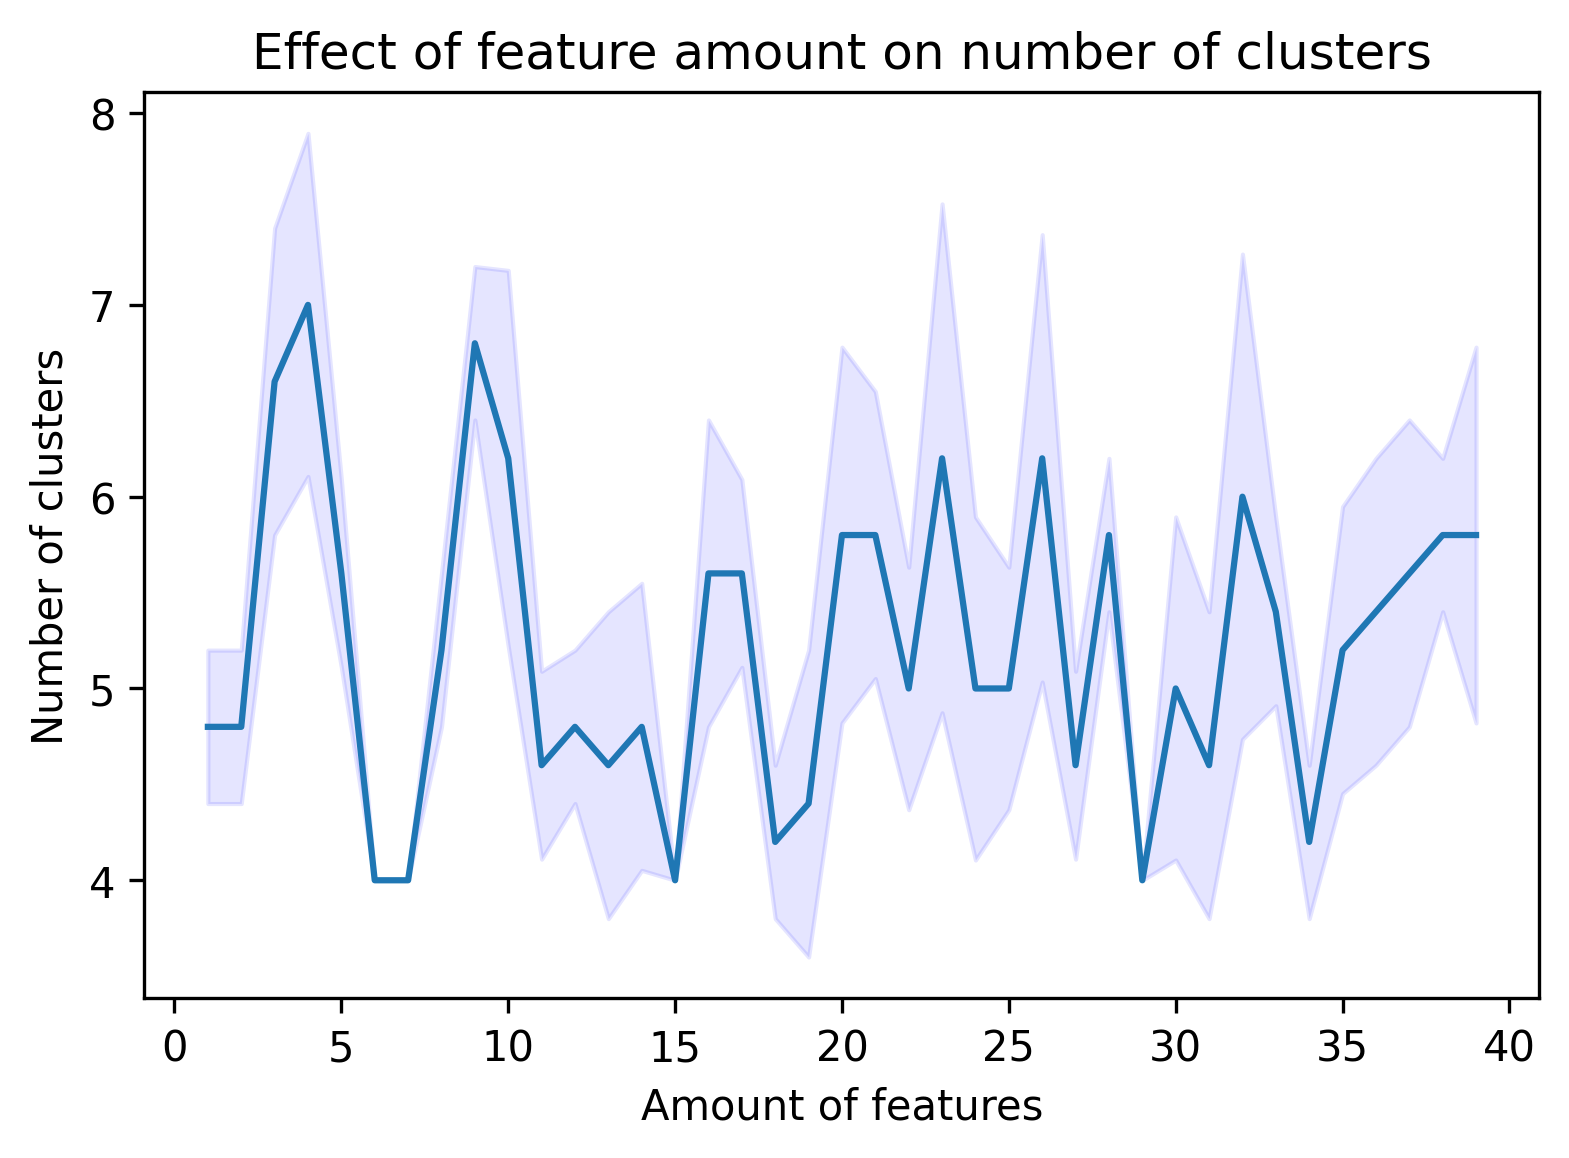

In [33]:
#### PLot results
upper_std = (np.array(biases)+np.array(bias_std))
lower_std = (np.array(biases)-np.array(bias_std))
plt.fill_between([i for i in range(1,FEATURE_AMOUNT)],lower_std, upper_std, color='b', alpha=.1)
plt.plot([i for i in range(1,FEATURE_AMOUNT)], biases)
plt.ylabel('Max negative bias')
plt.xlabel('Amount of features')
plt.title('Effect of feature amount on bias detection')
plt.show()

upper_std = (np.array(sillh_list)+np.array(std_sillh))
lower_std = (np.array(sillh_list)-np.array(std_sillh))
plt.fill_between([i for i in range(1,FEATURE_AMOUNT)],lower_std, upper_std, color='b', alpha=.1)
plt.plot([i for i in range(1,FEATURE_AMOUNT)], sillh_list)
plt.ylabel('Silhouette Score')
plt.xlabel('Amount of features')
plt.title('Effect of feature amount on Silhouette Score')
plt.show()

upper_std = (np.array(number_of_clusters)+np.array(std_number_of_clusters))
lower_std = (np.array(number_of_clusters)-np.array(std_number_of_clusters))
plt.fill_between([i for i in range(1,FEATURE_AMOUNT)],lower_std, upper_std, color='b', alpha=.1)
plt.plot([i for i in range(1,FEATURE_AMOUNT)], number_of_clusters)
plt.ylabel('Number of clusters')
plt.xlabel('Amount of features')
plt.title('Effect of feature amount on number of clusters')
plt.show()

In [32]:
print(biases)

[-0.17834570553787976, -0.29761903328099726, -2.5683573791523844, -1.8223812472256795, -0.43899184262680213, -0.20622661303098316, -0.20945992468242025, -0.24792600139274995, -0.3231442718404977, -0.27414816509581885, -0.21440587832161126, -0.29745978724359606, -0.26133518699672237, -0.2308658047022435, -0.24106140850831315, -0.2117114916686726, -0.19630313949806463, -0.14202940303968437, -0.14328979109357687, -0.2011231840488244, -0.20459391478511685, -0.1483241116409712, -0.175582052983985, -0.17628677012778032, -0.12070162712447678, -0.17381929260136678, -0.14062795360312388, -0.2684924452305314, -0.12971199026606303, -0.13861770766943207, -0.13071912085150922, -0.13754003722002167, -0.1391575522788118, -0.1241448551964253, -0.16710744173422043, -0.1379697159292428, -0.15258223037596289, -0.18278639734080668, -0.17257212700824387]


# Adding features 1by1, based on highest negative bias first

In [1]:
max_features = 15
all_features = sorted_features.copy()
selected_features = []
mean_biases = []
min_biases = []
max_biases = []

for i in range(max_features):
    feature_bias = dict()
    
    ## Add most discriminating feature to selected_features
    for feature in all_features[:]:
        current_feature_set = [feature]
        current_feature_set.extend(selected_features)
        print('FEATURE SET: ', current_feature_set)
        current_feature_set.extend(['predicted_value','true_value', 'errors'])
        
        #### CAlculate max negative bias, avg of 4 runs
        avg_bias_runs = []
        for j in range(4):
            results = hbac_kmeans.hbac_kmeans(df[current_feature_set], 0.8, show_plot=False)
            c, max_neg_bias = hbac_kmeans.get_max_bias_cluster(results, printing=False)
            avg_bias_runs.append(max_neg_bias)
        feature_bias[feature] = mean(avg_bias_runs)
    
    
    best_feature = min(feature_bias, key=feature_bias.get)
    all_features.remove(best_feature)
    selected_features.append(best_feature)
    
    mean_biases.append(mean(feature_bias.values()))
    min_biases.append(min(feature_bias.values()))
    max_biases.append(max(feature_bias.values()))

    print('\n\n')
    print('Best feature set :', selected_features, feature_bias[best_feature])
    print('\n\n')
    
        
        

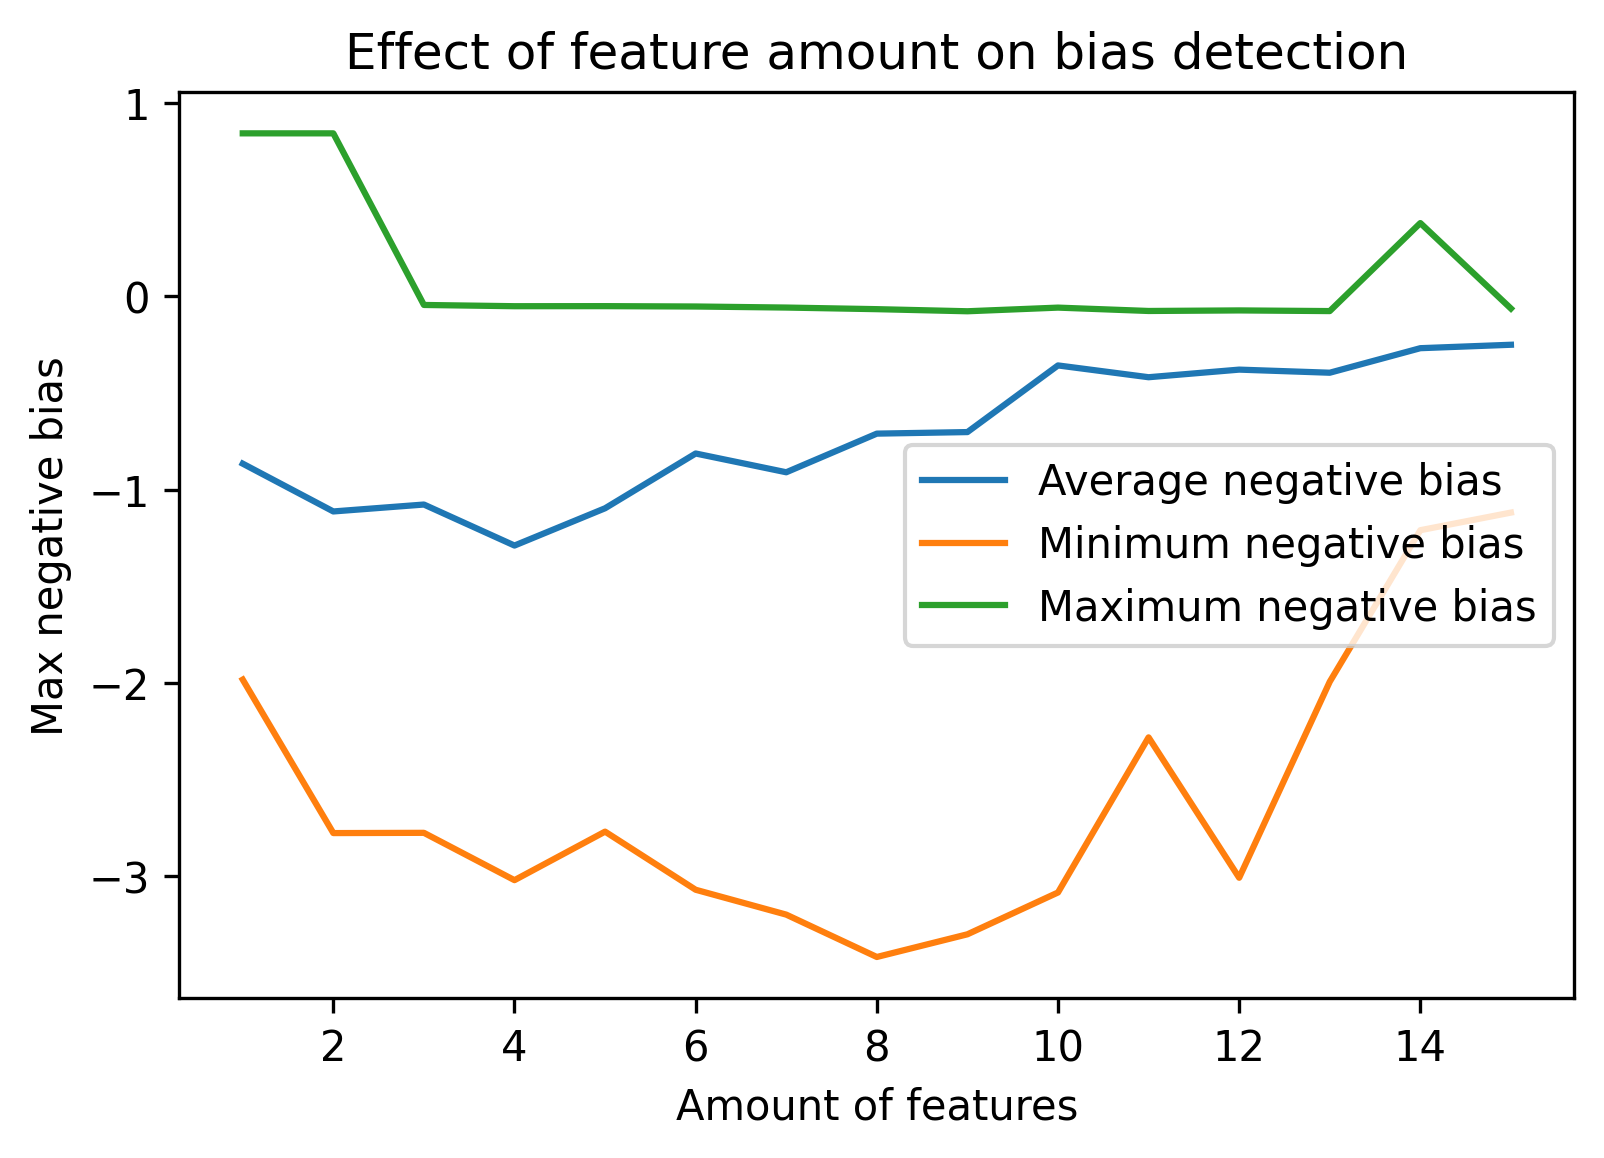

In [11]:
#### PLot results
# upper_std = (np.array(biases)+np.array(bias_std))
# lower_std = (np.array(biases)-np.array(bias_std))
# plt.fill_between([i for i in range(1,FEATURE_AMOUNT)],lower_std, upper_std, color='b', alpha=.1)

plt.plot([i for i in range(1,max_features+1)], mean_biases, label='Average negative bias')
plt.plot([i for i in range(1,max_features+1)], min_biases, label='Minimum negative bias')
plt.plot([i for i in range(1,max_features+1)], max_biases, label='Maximum negative bias')
plt.ylabel('Bias')
plt.xlabel('Amount of features')
plt.title('Feature selection based on negative bias optimization')
plt.legend()
plt.show()


In [12]:

# Best feature set : ['overgewicht', 
#                     'bevolkingsdichtheid', 'bouwjaar_x', 'geweldsenseksuelemisdrijven', 
#                     'interior_type_shell', 'score_voorzieningen', 
#                     'huishoudenstotaal', 'geweld', 'energy_label_d', 
#                     'vernielingen', 'parking_type_betaald'] -2.280493375256789

# Best feature set : ['overgewicht', 'bevolkingsdichtheid', 'bouwjaar_x', 
# 'geweldsenseksuelemisdrijven', 'interior_type_shell', 'score_voorzieningen', 
# 'huishoudenstotaal', 'geweld', 'energy_label_d', 'vernielingen', 'parking_type_betaald', 'ordeverstoring', 
# 'parking_type_garage', 'bouwjaarvanaf'] -1.2089203858978959

# Best feature set : ['overgewicht', 'bevolkingsdichtheid', 'bouwjaar_x', 'geweldsenseksuelemisdrijven', 'interior_type_shell', 'score_voorzieningen', 'huishoudenstotaal', 'geweld', 'energy_label_d', 'vernielingen', 'parking_type_betaald', 'ordeverstoring', 'parking_type_garage', 'bouwjaarvanaf', 'energy_label_e'] -1.1178192002323142

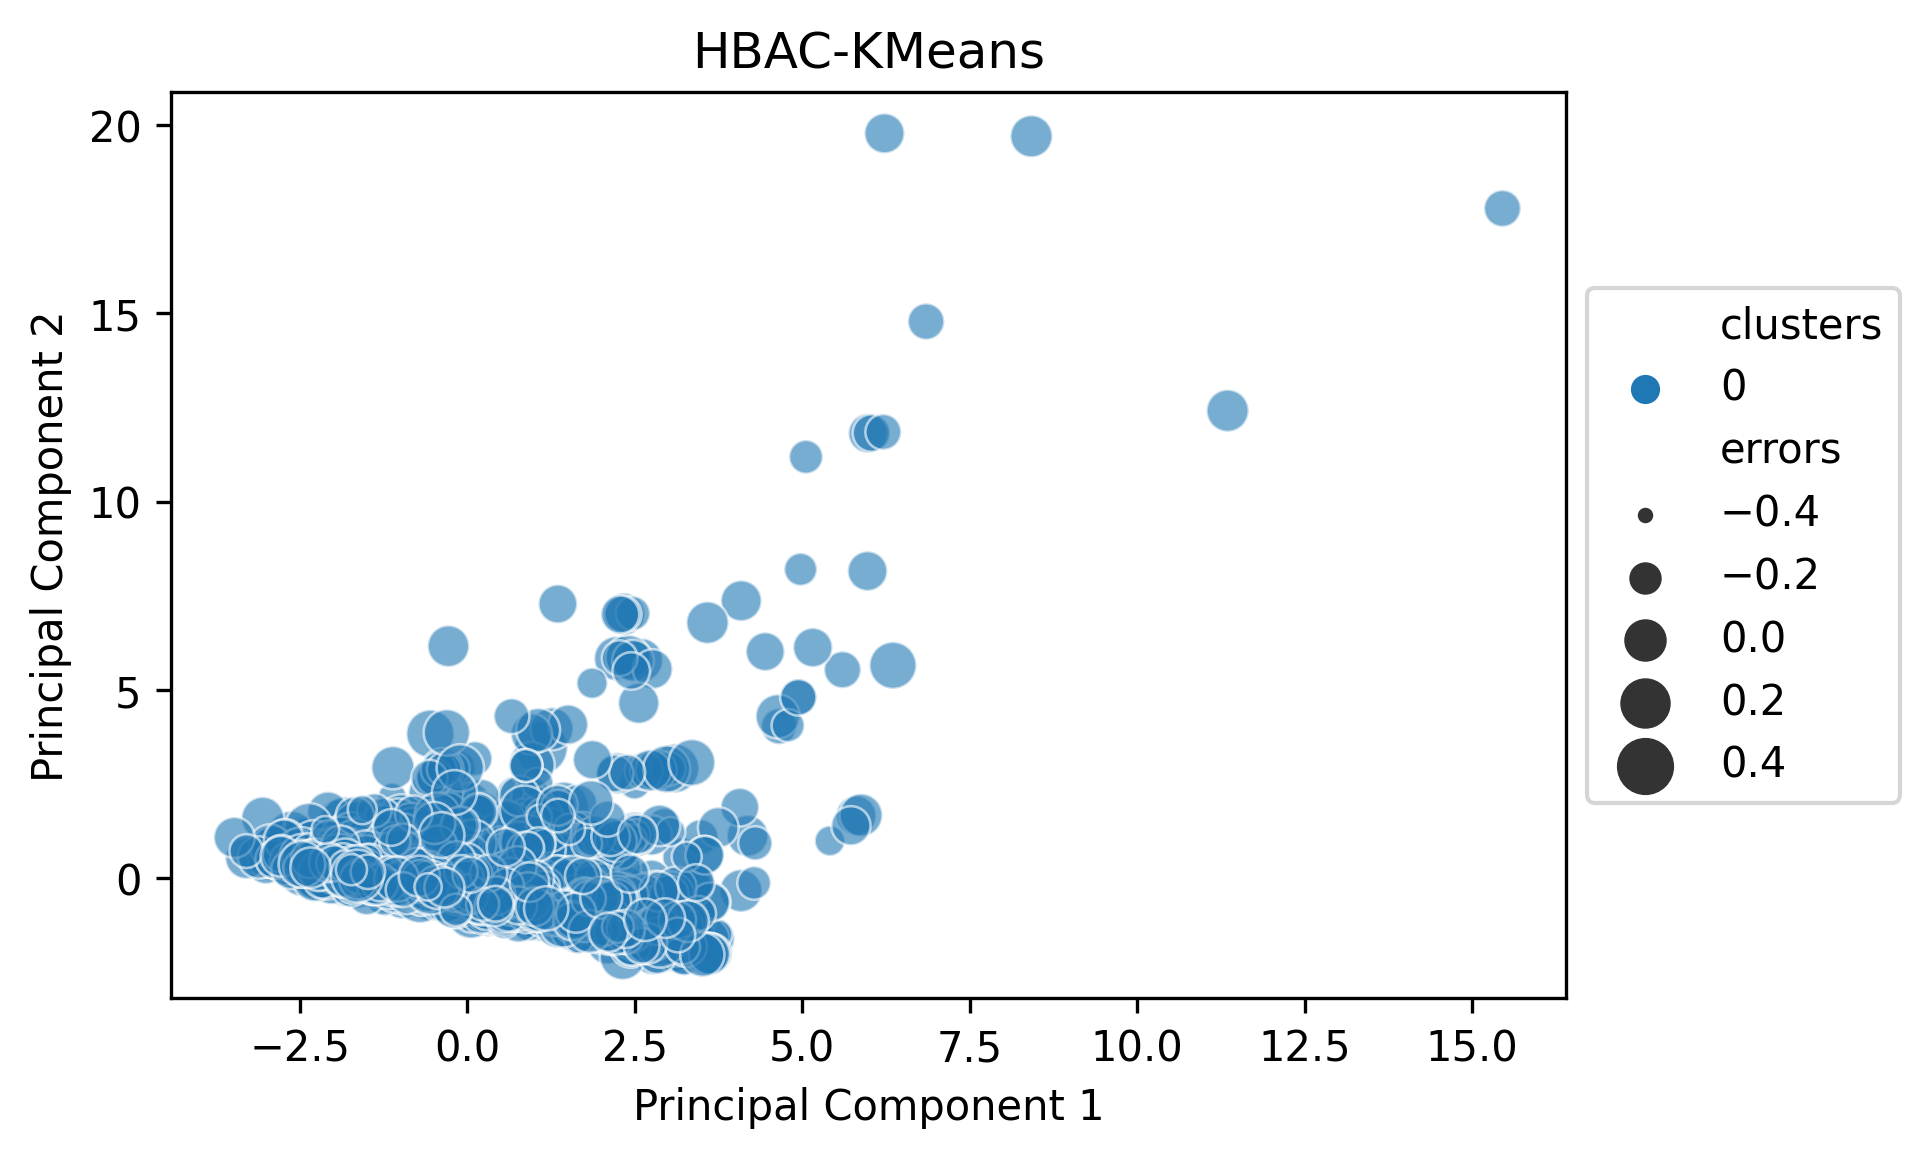

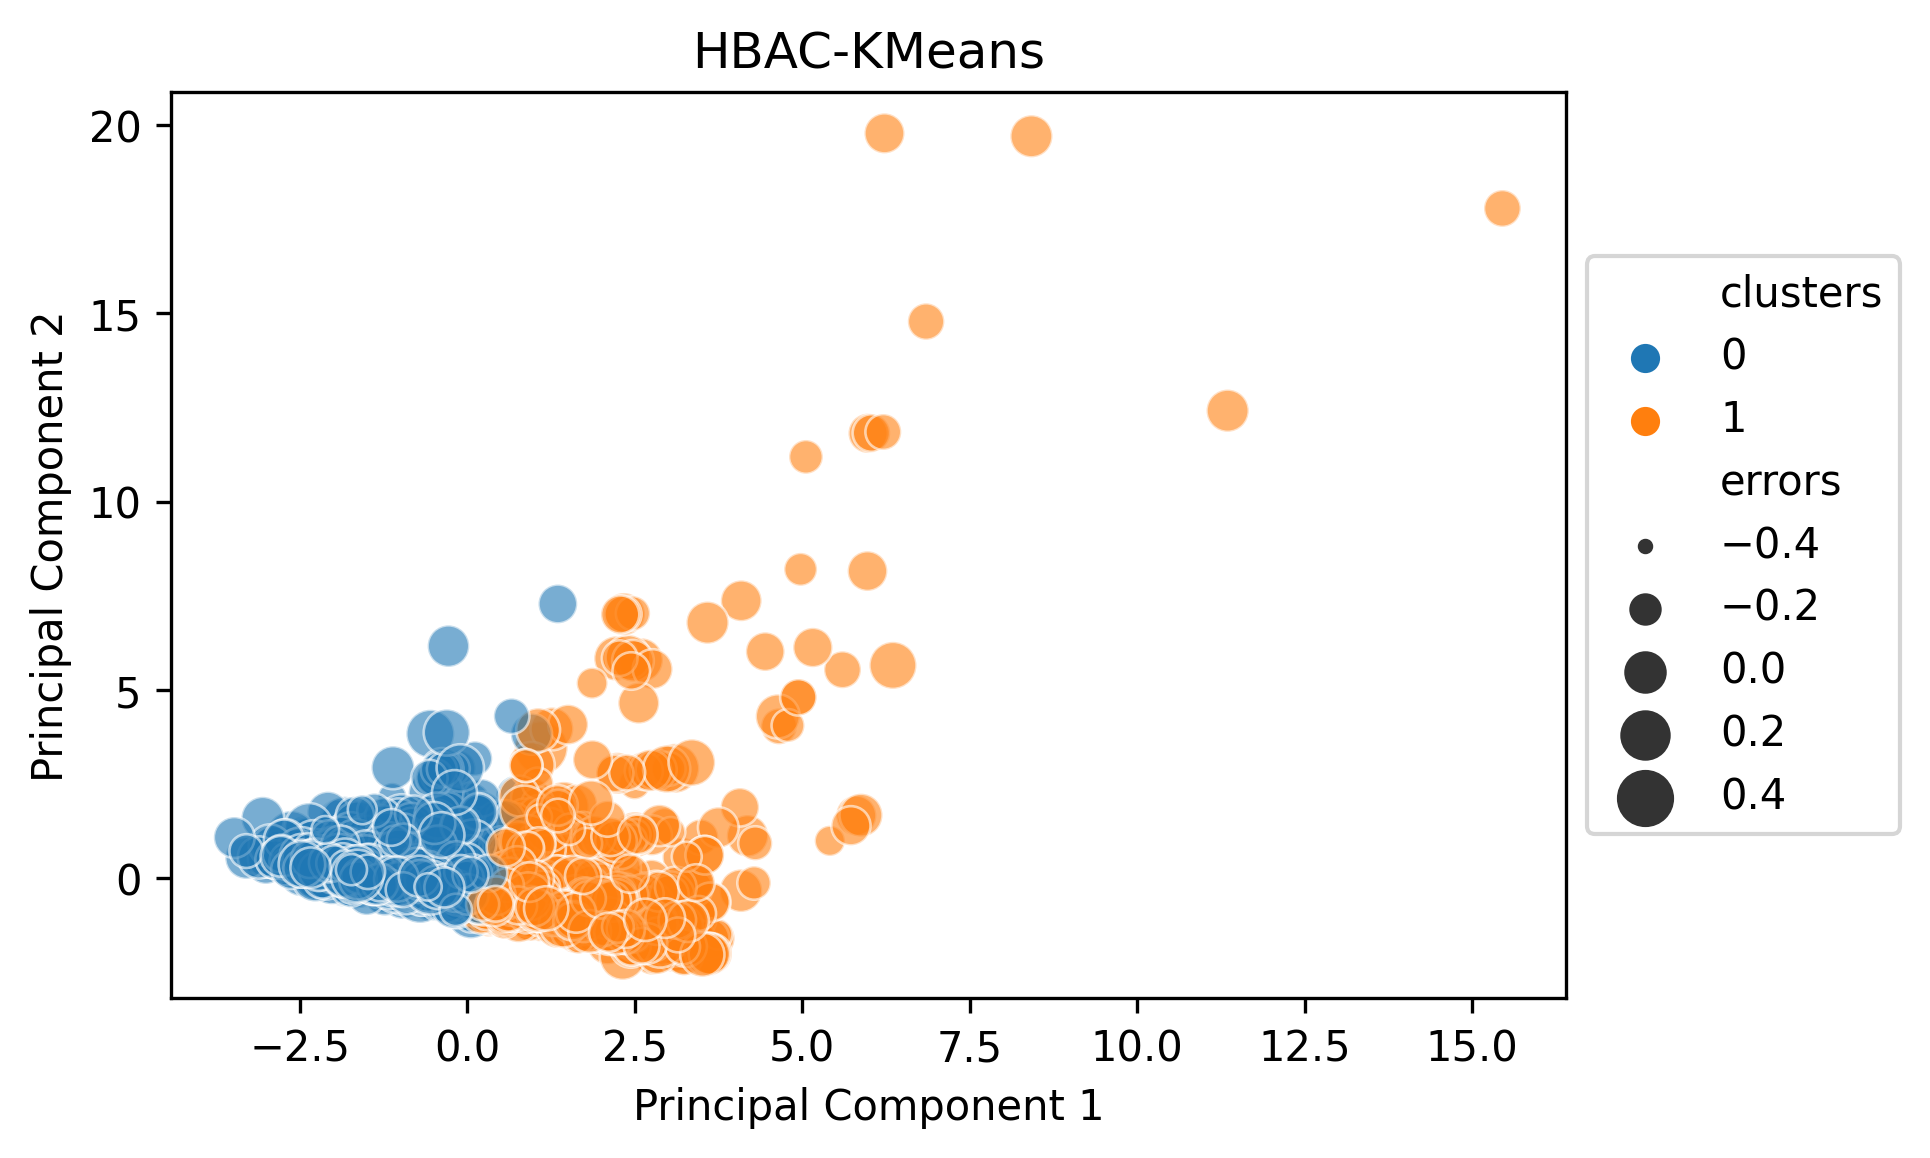

CLUSTER QUALITY
Silhouetter Score: 0.291
DB index: 1.521
CH index: 851.251


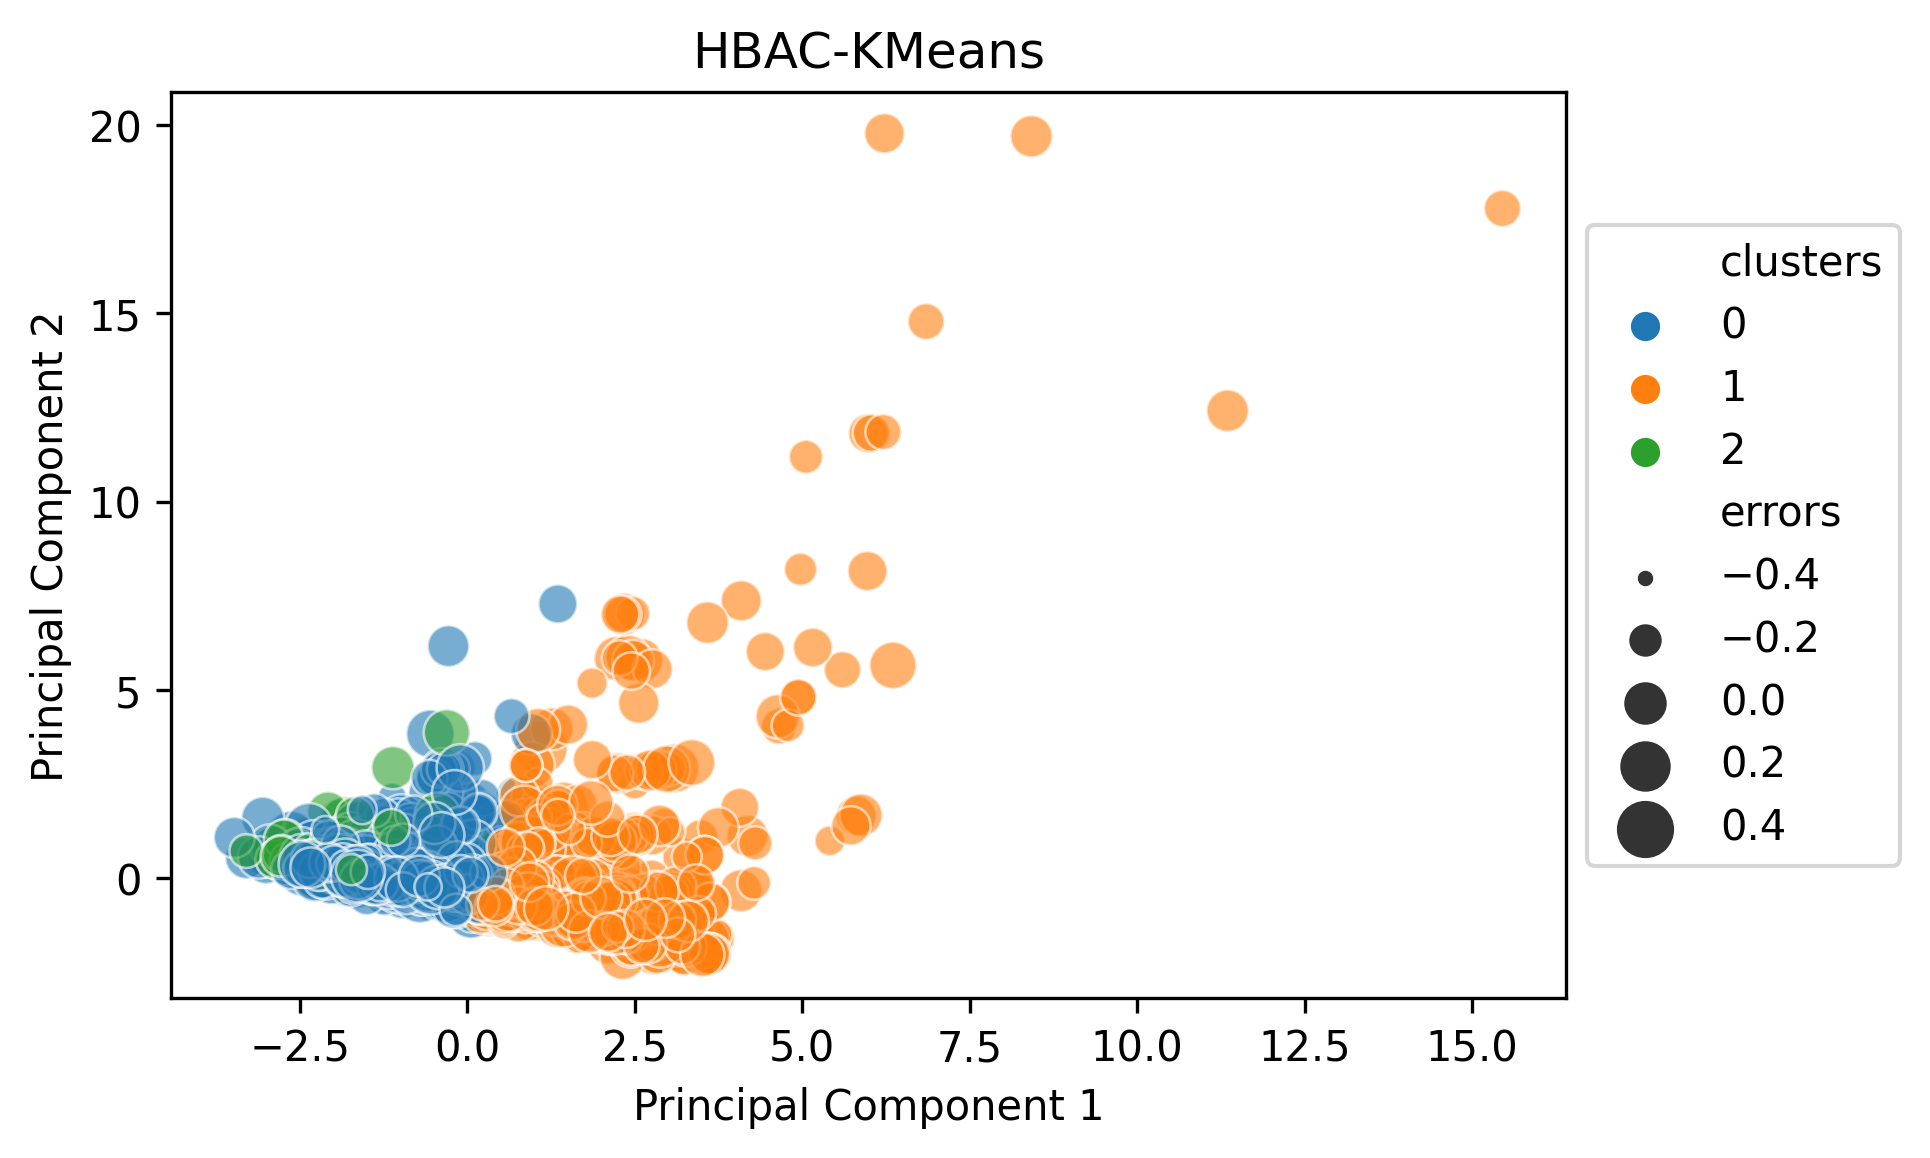

CLUSTER QUALITY
Silhouetter Score: 0.313
DB index: 1.240
CH index: 666.678


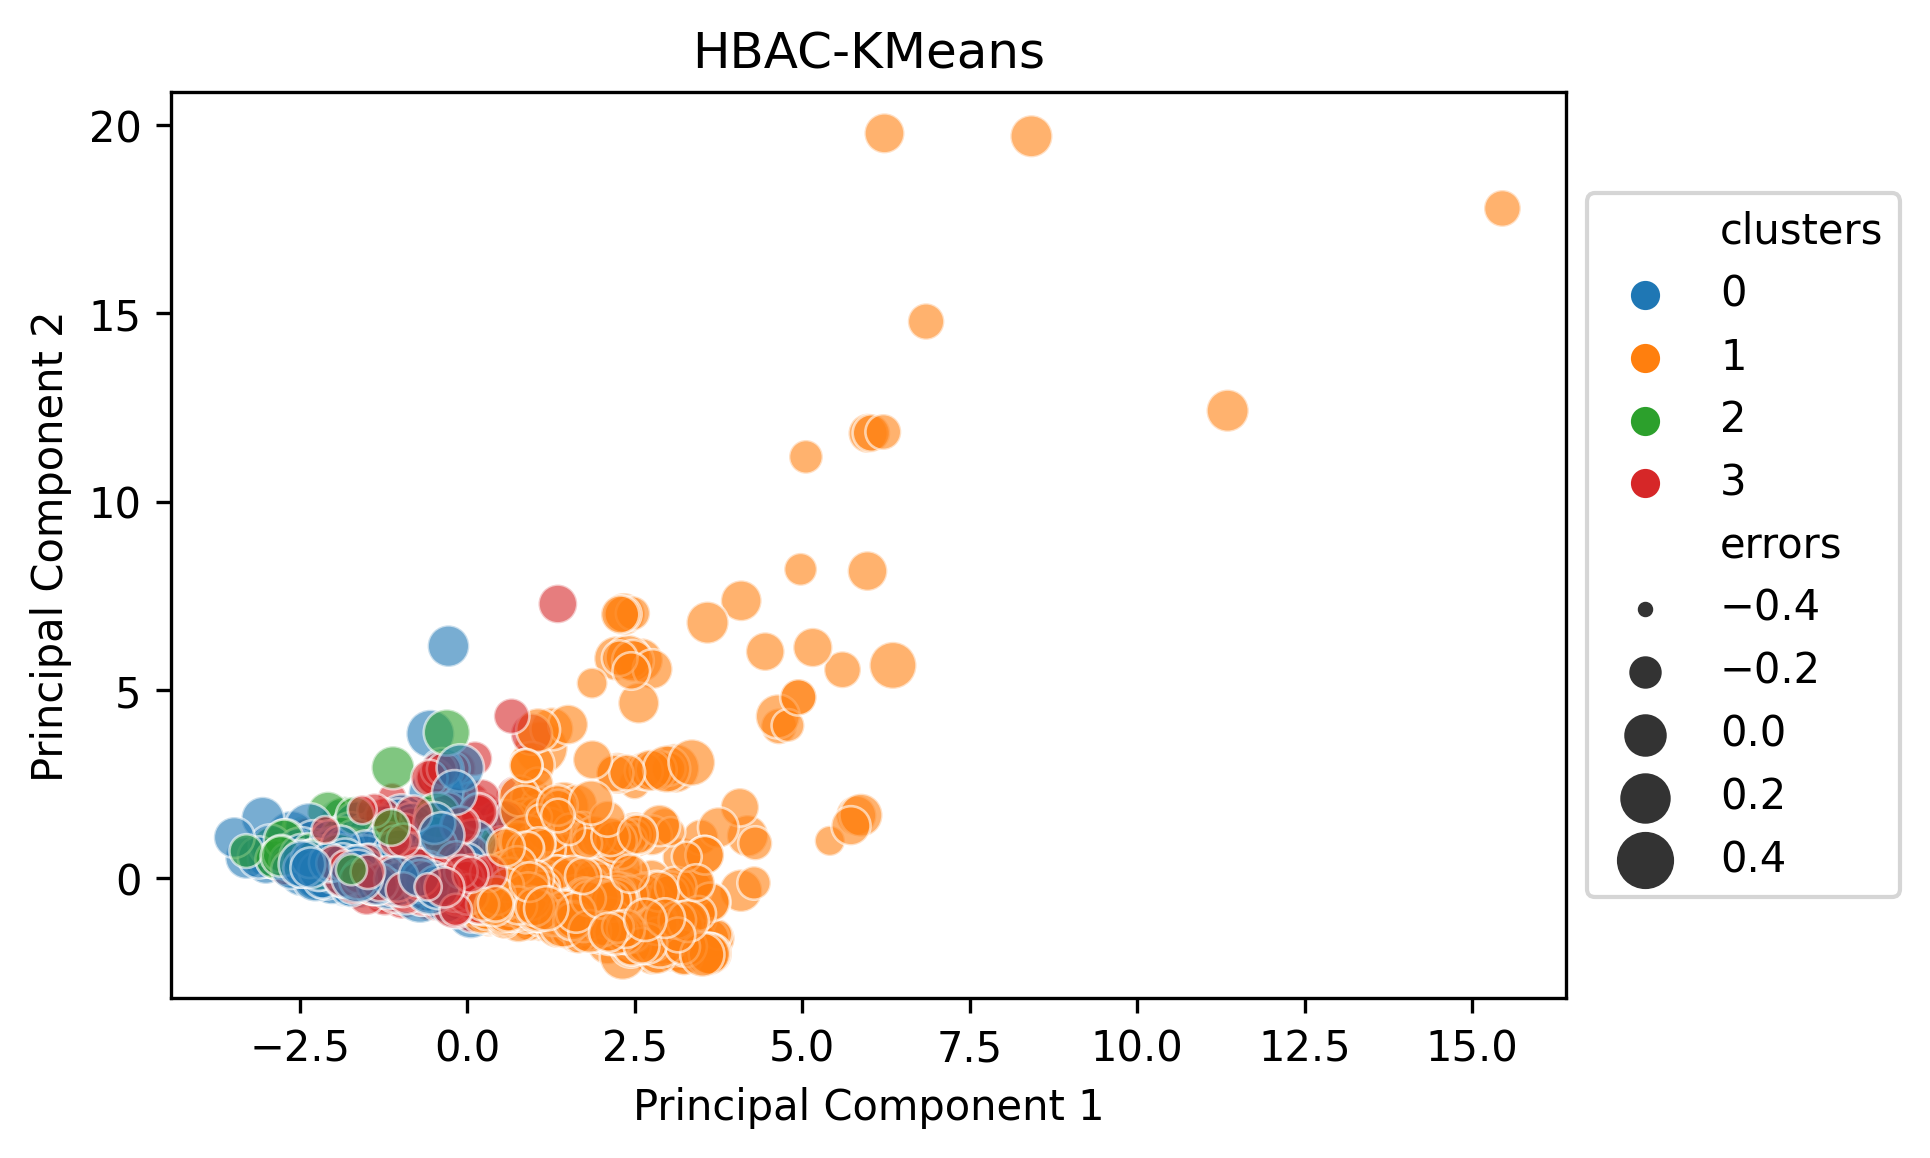

CLUSTER QUALITY
Silhouetter Score: 0.130
DB index: 1.626
CH index: 506.194


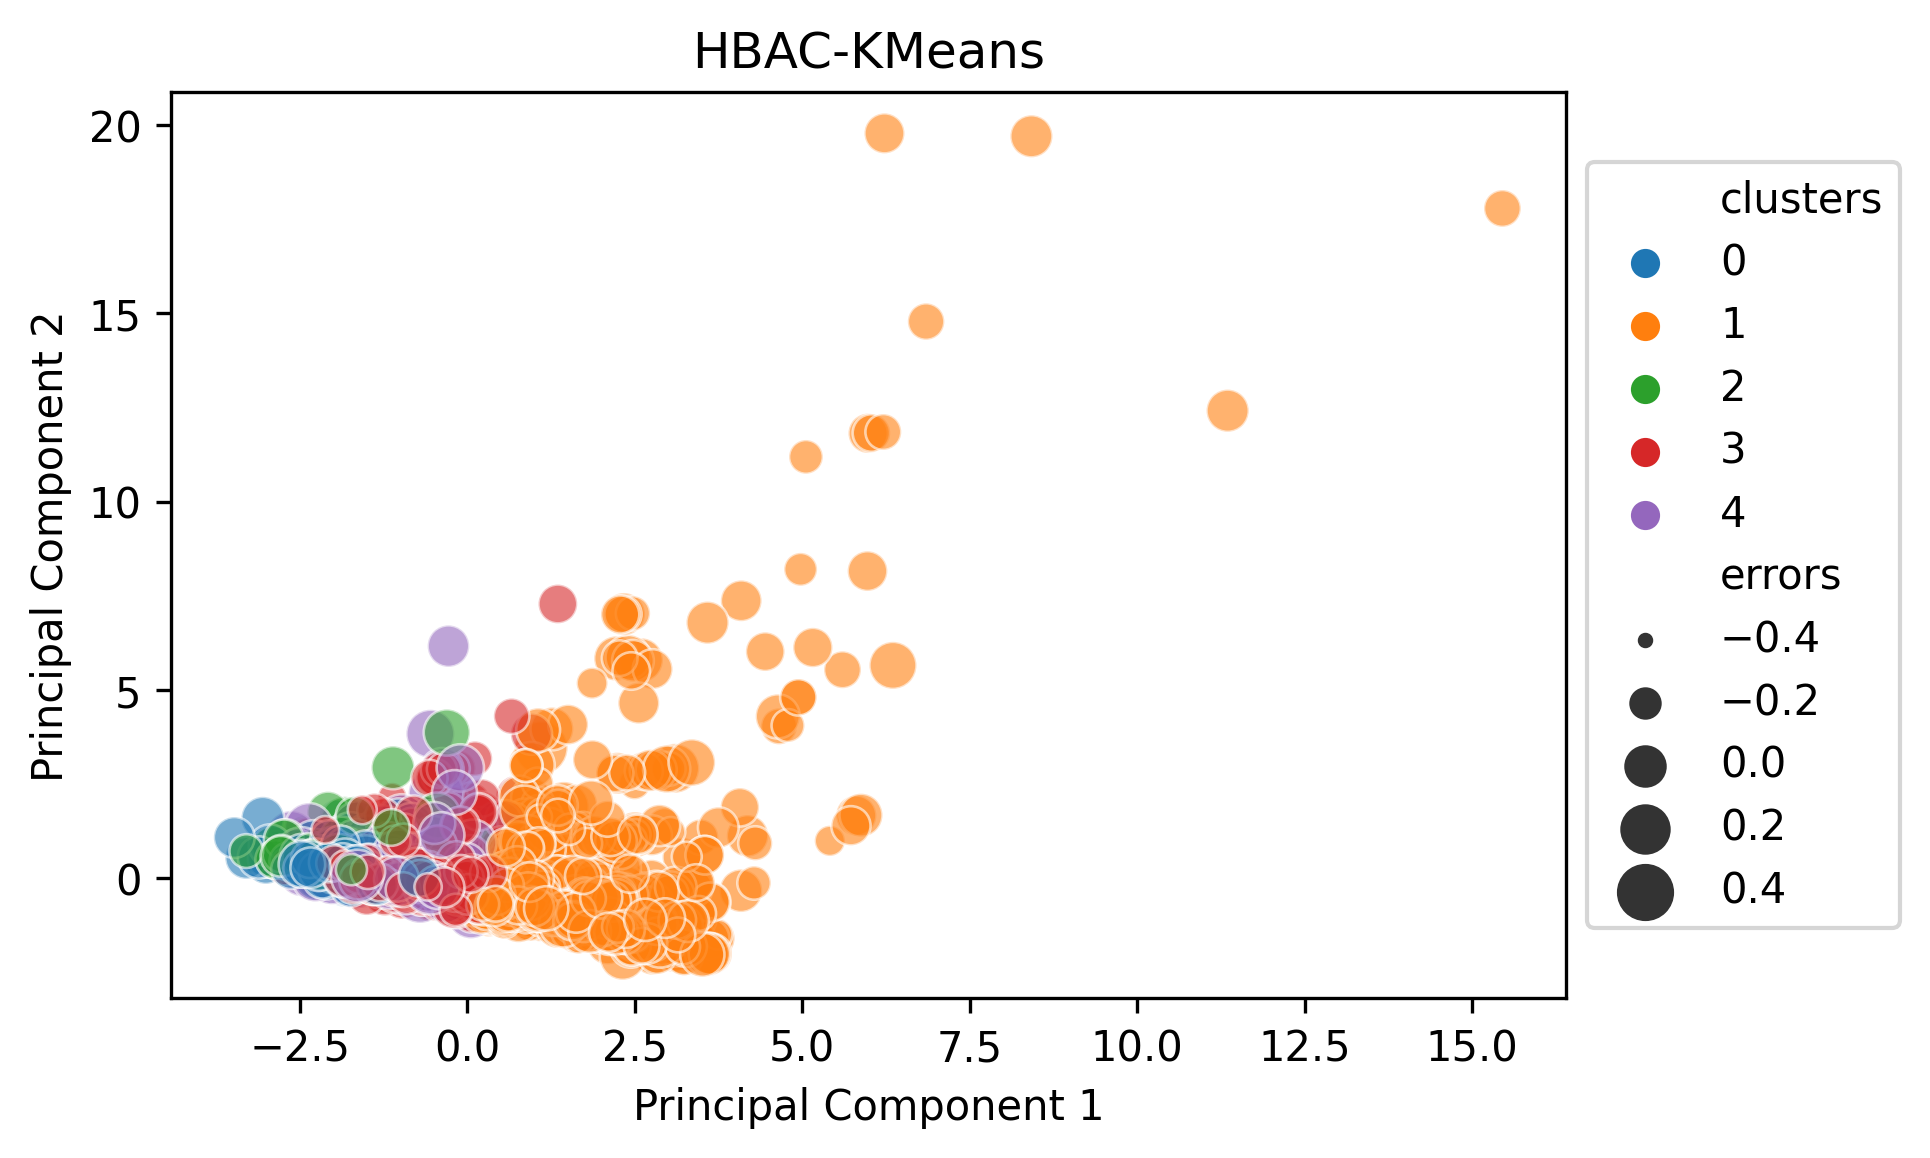

CLUSTER QUALITY
Silhouetter Score: 0.089
DB index: 1.634
CH index: 397.020


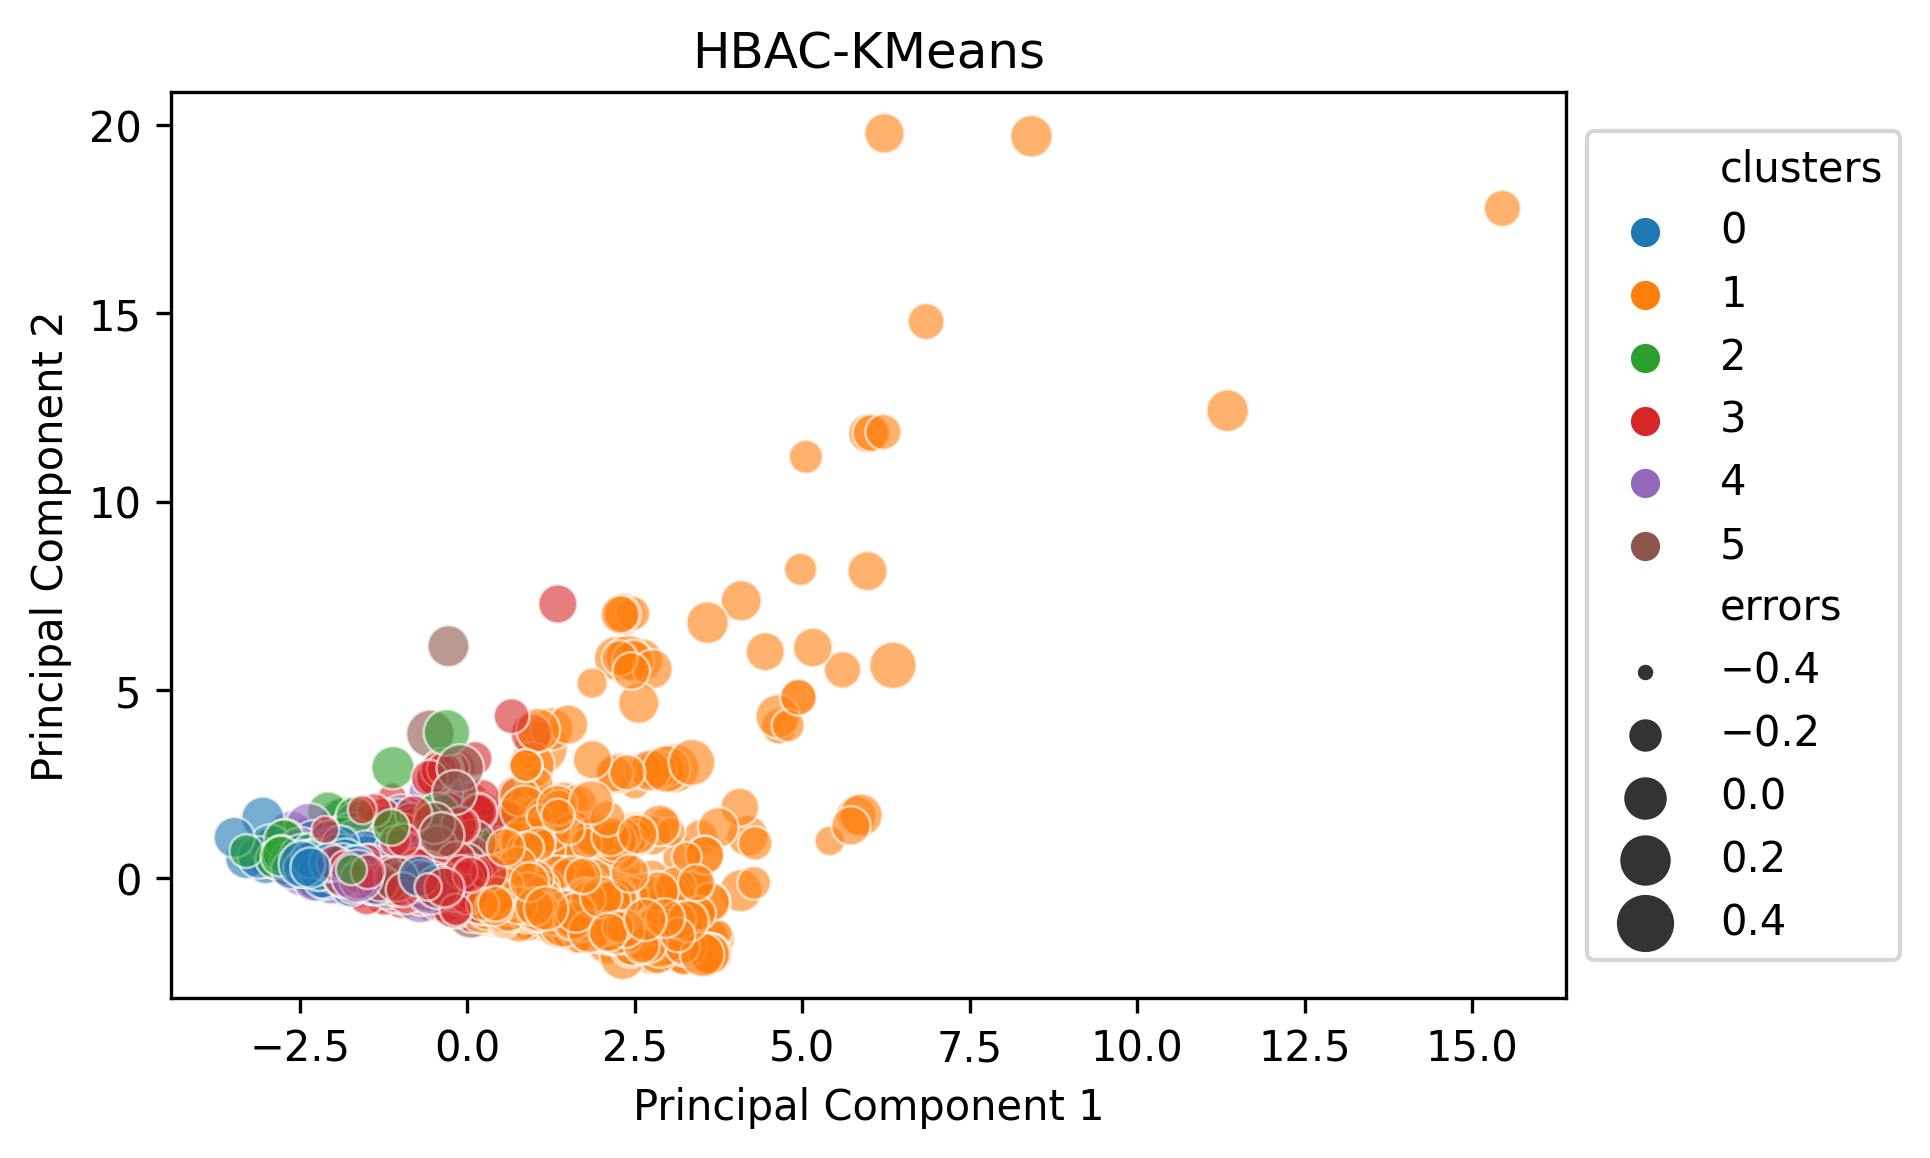

CLUSTER QUALITY
Silhouetter Score: 0.079
DB index: 1.761
CH index: 322.333
1 has bias 0.05835791270089574
3 has bias -0.0578706547164044
0 has bias 0.05783386997075257
2 has bias -0.056089236518595986
5 has bias -0.4120502401126819
4 has bias -3.2994410708735415
cluster with the highest discriminating bias: 4


In [14]:
eight_best_features = ['overgewicht', 'bevolkingsdichtheid', 'bouwjaar_x', 'geweldsenseksuelemisdrijven', 'interior_type_shell', 'score_voorzieningen', 'huishoudenstotaal', 'geweld']
eight_best_features.extend(['predicted_value', 'true_value' ,'errors'])
results = hbac_kmeans.hbac_kmeans(df[eight_best_features], 0.8, show_plot=True)
c, max_neg_bias = hbac_kmeans.get_max_bias_cluster(results, printing=False)


# Adding features 1by1, based on highest Silhouette Score first


In [4]:
max_features = 15
all_features = sorted_features.copy()
selected_features = []
mean_sill = []
best_sill = []
mean_biases = []
best_neg_bias = []

for i in range(max_features):
    feature_sill_score = dict()
    feature_bias = dict()
    
    ## Add most discriminating feature to selected_features
    for feature in all_features[:]:
        current_feature_set = [feature]
        current_feature_set.extend(selected_features)
        #print('FEATURE SET: ', current_feature_set)
        current_feature_set.extend(['predicted_value','true_value', 'errors'])
        
        #### Calculate max negative bias, avg of ... runs
        avg_sill_runs = []
        avg_bias_runs = []
        for j in range(3):
            results = hbac_kmeans.hbac_kmeans(df[current_feature_set], 0.8, show_plot=False)
            c, max_neg_bias = hbac_kmeans.get_max_bias_cluster(results, printing=False)
            avg_bias_runs.append(max_neg_bias)
            
            ##### If only 1 cluster could be made:
            if len(results['clusters'].unique()) == 1:
                sill_score = -1
            else:
                sill_score = metrics.silhouette_score( results.drop(['clusters', 'new_clusters', 'predicted_value', 'true_value', 'errors'], axis=1),
                                                  results['clusters'])
            avg_sill_runs.append(sill_score)
        feature_sill_score[feature] = mean(avg_sill_runs)
        feature_bias[feature] = mean(avg_bias_runs)
    
    ####### Choose based on Silhouette score
    best_feature = max(feature_sill_score, key=feature_sill_score.get)
    
    ####### Choose based on Silhouette score
    ### best_feature = min(feature_bias, key=feature_bias.get)

    ####### Choose based on Silhouette AND Bias ?
    
    
    all_features.remove(best_feature)
    selected_features.append(best_feature)
    
    mean_sill.append(mean(feature_sill_score.values()))
    mean_biases.append(mean(feature_bias.values()))
    best_sill.append(max(feature_sill_score.values()))
    best_neg_bias.append(min(feature_bias.values()))
    
    print('\n\n')
    print('Best feature set :', selected_features, feature_sill_score[best_feature])
    print('\n\n')
    




Best feature set : ['listing_residential_type_apartment'] 0.653569300544438






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house'] 0.7256734170943083






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats'] 0.7255005674047089






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage'] 0.6845377755213227






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f'] 0.6399065718895031






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f', 'ordeverstoring'] 0.5961886281914508






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_hou

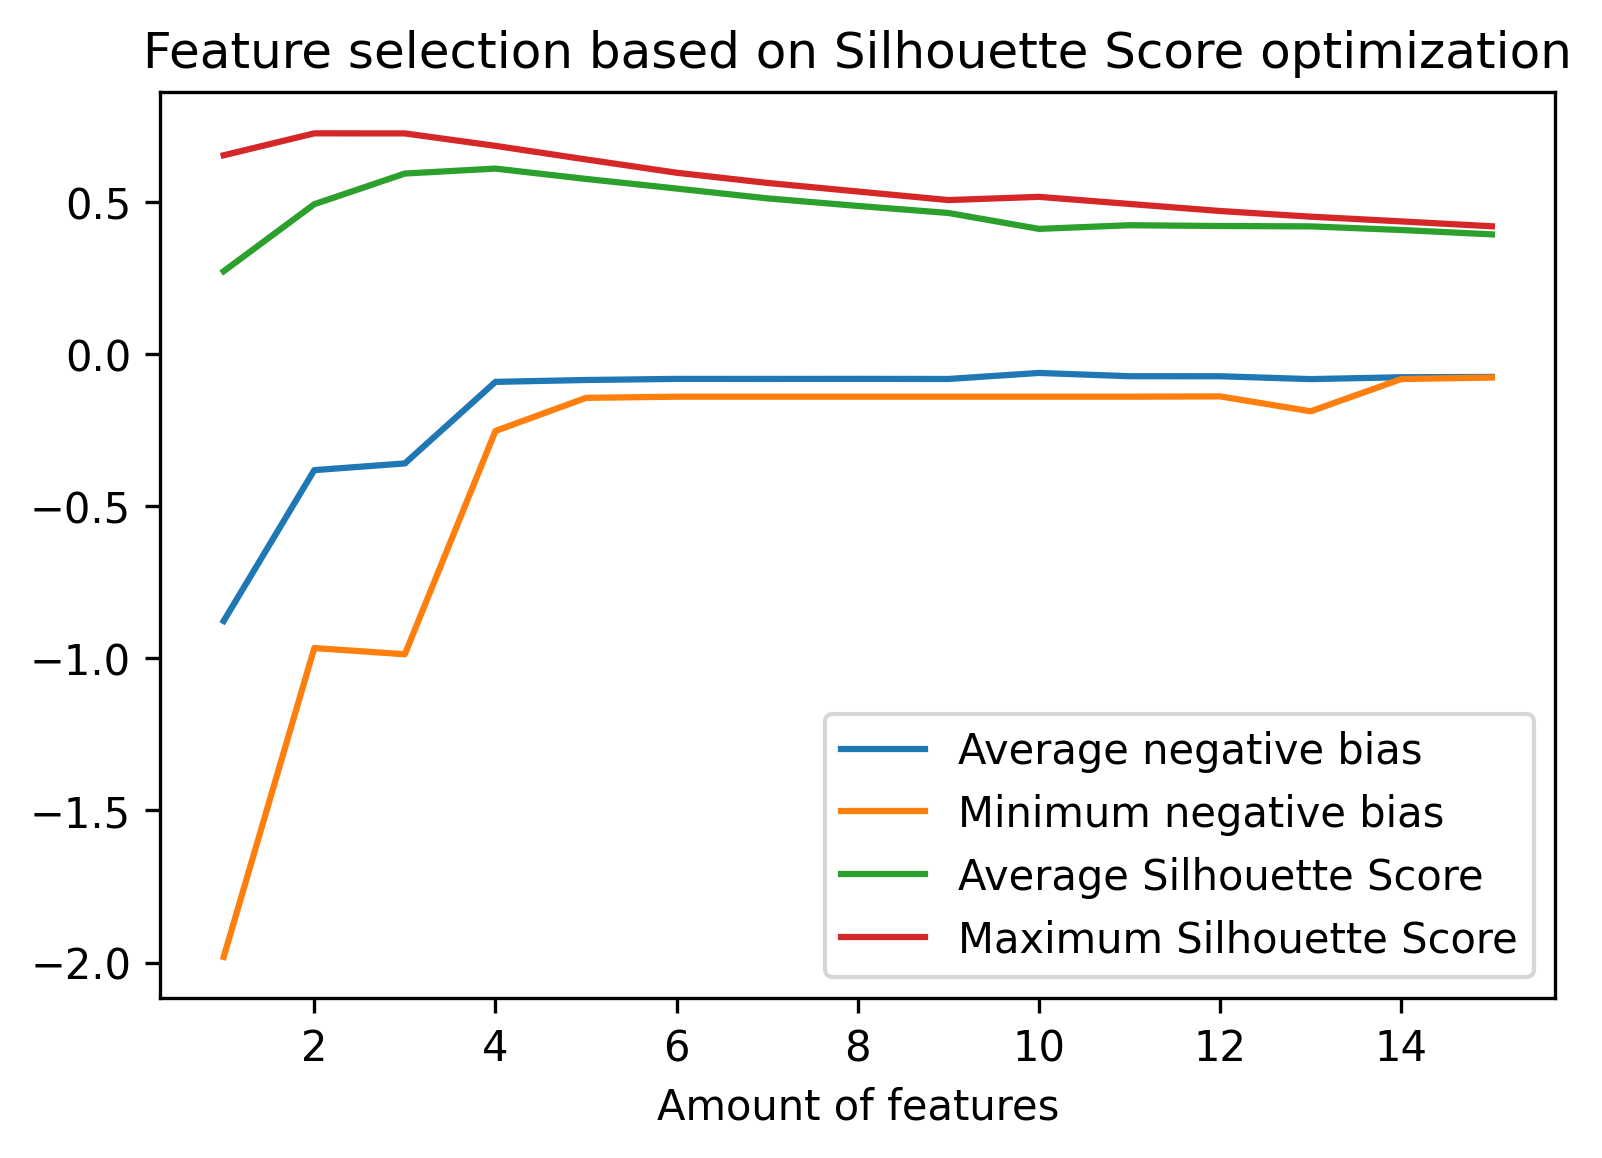

In [5]:
plt.plot([i for i in range(1,max_features+1)], mean_biases, label='Average negative bias')
plt.plot([i for i in range(1,max_features+1)], best_neg_bias, label='Minimum negative bias')
plt.plot([i for i in range(1,max_features+1)], mean_sill, label='Average Silhouette Score')
plt.plot([i for i in range(1,max_features+1)], best_sill, label='Maximum Silhouette Score')
plt.xlabel('Amount of features')
plt.title('Feature selection based on Silhouette Score optimization')
plt.legend()
plt.show()

In [8]:
max_features = 40
all_features = sorted_features.copy()
selected_features = []
mean_sill = []
best_sill = []
mean_biases = []
best_neg_bias = []

for i in range(max_features):
    feature_sill_score = dict()
    feature_bias = dict()
    
    ## Add most discriminating feature to selected_features
    for feature in all_features[:]:
        current_feature_set = [feature]
        current_feature_set.extend(selected_features)
        #print('FEATURE SET: ', current_feature_set)
        current_feature_set.extend(['predicted_value','true_value', 'errors'])
        
        #### Calculate max negative bias, avg of ... runs
        avg_sill_runs = []
        avg_bias_runs = []
        for j in range(3):
            results = hbac_kmeans.hbac_kmeans(df[current_feature_set], 0.8, show_plot=False)
            c, max_neg_bias = hbac_kmeans.get_max_bias_cluster(results, printing=False)
            avg_bias_runs.append(max_neg_bias)
            
            ##### If only 1 cluster could be made:
            if len(results['clusters'].unique()) == 1:
                sill_score = -1
            else:
                sill_score = metrics.silhouette_score( results.drop(['clusters', 'new_clusters', 'predicted_value', 'true_value', 'errors'], axis=1),
                                                  results['clusters'])
            avg_sill_runs.append(sill_score)
        feature_sill_score[feature] = mean(avg_sill_runs)
        feature_bias[feature] = mean(avg_bias_runs)
    
    ####### Choose based on Silhouette score
    best_feature = max(feature_sill_score, key=feature_sill_score.get)
    
    ####### Choose based on Silhouette score
    ### best_feature = min(feature_bias, key=feature_bias.get)

    ####### Choose based on Silhouette AND Bias ?
    
    
    all_features.remove(best_feature)
    selected_features.append(best_feature)
    
    mean_sill.append(mean(feature_sill_score.values()))
    mean_biases.append(mean(feature_bias.values()))
    best_sill.append(max(feature_sill_score.values()))
    best_neg_bias.append(min(feature_bias.values()))
    
    print('\n\n')
    print('Best feature set :', selected_features, feature_sill_score[best_feature])
    print('\n\n')
    




Best feature set : ['listing_residential_type_apartment'] 0.653569300544438






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house'] 0.7256734170943083






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats'] 0.7255005674047089






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage'] 0.6845377755213227






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f'] 0.6399065718895031






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f', 'ordeverstoring'] 0.5961886281914508






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_hou




Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f', 'ordeverstoring', 'geweldsenseksuelemisdrijven', 'geweld', 'inbraken', 'geregistreerdeoverlast', 'vernielingen', 'number_of_floors_building', 'afstandtotgrotesupermarkt', 'afstandtotparkofplantsoen', 'berovingen', 'huishoudenstotaal', 'personenautosnaaroppervlakte', 'gemiddeldaardgasverbruiktotaal', 'energy_label_g', 'opgesteldvermogenvanzonnepanelen', 'percentagebewoond', 'interior_type_shell', 'leeftijdscategorie_0_15', 'garage', 'cafebinnenkm'] 0.2542140905530777






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f', 'ordeverstoring', 'geweldsenseksuelemisdrijven', 'geweld', 'inbraken', 'geregistreerdeoverlast', 'vernielingen', 'number_of_floors_building', 'afstandtotgrotesupermarkt', 'afstandtotparkofplants




Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_house', 'parking_type_parkeerplaats', 'parking_type_garage', 'energy_label_f', 'ordeverstoring', 'geweldsenseksuelemisdrijven', 'geweld', 'inbraken', 'geregistreerdeoverlast', 'vernielingen', 'number_of_floors_building', 'afstandtotgrotesupermarkt', 'afstandtotparkofplantsoen', 'berovingen', 'huishoudenstotaal', 'personenautosnaaroppervlakte', 'gemiddeldaardgasverbruiktotaal', 'energy_label_g', 'opgesteldvermogenvanzonnepanelen', 'percentagebewoond', 'interior_type_shell', 'leeftijdscategorie_0_15', 'garage', 'cafebinnenkm', 'leeftijdscategorie_45_65', 'bouwjaar_x', 'afstandtotopenbaargroentotaal', 'leeftijdscategorie_15_25', 'opleidingsniveauhoog', 'energy_label_c', 'aantalinwoners', 'storage', 'gemiddeldinkomenperinkomensontvanger', 'gemiddeldewoningwaarde', 'goedzeergoedervarengezondheid'] 0.168262220324159






Best feature set : ['listing_residential_type_apartment', 'listing_residential_type_h

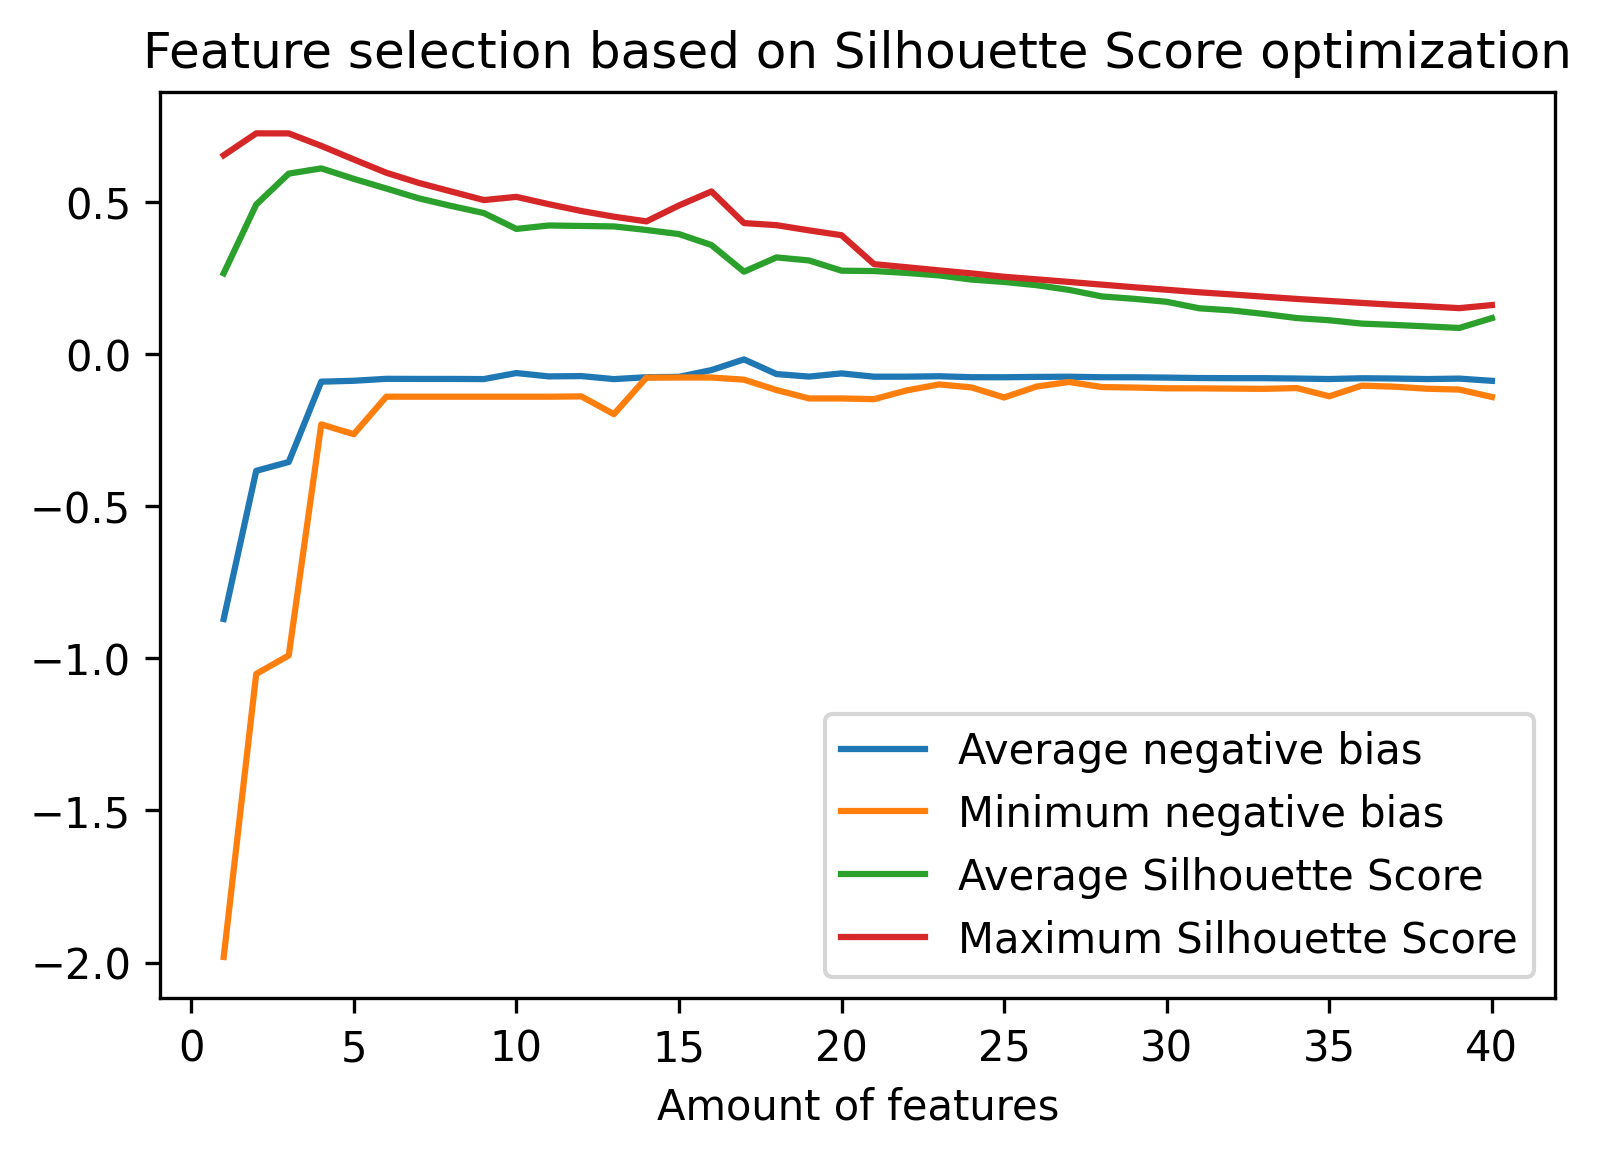

In [9]:
plt.plot([i for i in range(1,max_features+1)], mean_biases, label='Average negative bias')
plt.plot([i for i in range(1,max_features+1)], best_neg_bias, label='Minimum negative bias')
plt.plot([i for i in range(1,max_features+1)], mean_sill, label='Average Silhouette Score')
plt.plot([i for i in range(1,max_features+1)], best_sill, label='Maximum Silhouette Score')
plt.xlabel('Amount of features')
plt.title('Feature selection based on Silhouette Score optimization')
plt.legend()
plt.show()